<a href="https://www.kaggle.com/code/ndannnop/computer-vision?scriptVersionId=239413396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install pybcf pysam keras-layer-normalization

In [1]:
# import libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import os
import random
import math # Needed for ceiling division

# Helper function to extract patches (updated for grayscale)
def extract_patches(image_array, num_patch=3, patch_size=(105, 105)):
    """
    Extracts a specified number of random patches from a single image array.
    Handles both grayscale (2D) and color (3D) images.

    Args:
        image_array (np.ndarray): The input image (Height, Width) or (Height, Width, Channels).
        num_patch (int): The number of patches to extract.
        patch_size (tuple): The (height, width) of the patches.

    Returns:
        list[np.ndarray]: A list containing the extracted patch arrays.
                          Patches will be 2D (H, W) if input is grayscale.
                          Returns an empty list if image is smaller than patch size.
    """
    patches = []
    if image_array.ndim == 2: # Grayscale
        h, w = image_array.shape
        is_grayscale = True
    elif image_array.ndim == 3: # Color
        h, w, _ = image_array.shape
        is_grayscale = False
    else:
        print(f"Warning: Unexpected image array dimension: {image_array.ndim}. Skipping patch extraction.")
        return []

    patch_h, patch_w = patch_size

    # Check if image is large enough for at least one patch
    if h < patch_h or w < patch_w:
        # print(f"Warning: Image shape ({h}, {w}) is smaller than patch size ({patch_h}, {patch_w}). Skipping patch extraction for this image.")
        return [] # Return empty list if image is too small

    for _ in range(num_patch):
        # Ensure random coordinates are within valid bounds
        x = np.random.randint(0, w - patch_w + 1)
        y = np.random.randint(0, h - patch_h + 1)
        if is_grayscale:
            patch = image_array[y:y + patch_h, x:x + patch_w] # Shape: (patch_h, patch_w)
        else:
             patch = image_array[y:y + patch_h, x:x + patch_w, :] # Shape: (patch_h, patch_w, C) - Kept for generality but not used in this specific request
        patches.append(patch)
    return patches
    
class BCFImagePatchDataset(Dataset):
    """
    PyTorch Dataset for loading either images from a BCF file or from a folder of JPEG files,
    and extracting patches on the fly. Loads images as grayscale.
    """
    def __init__(self, data_source, label_file=None, num_patch=3, patch_size=(105, 105)):
        """
        Initializes the dataset. Can handle both BCF files and JPEG images.

        Args:
            data_source (str): Path to the BCF file or directory containing JPEG images.
            label_file (str): Path to the label file (required only for BCF files).
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): (height, width) of patches.
        """
        self.data_source = data_source
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size

        self.labels = None
        self.image_filenames = []

        # Determine whether the dataset is based on BCF or JPEG files
        if data_source.endswith('.bcf'):
            self._read_bcf_metadata()
        else:
            self._read_image_filenames()

    def _read_bcf_metadata(self):
        """Reads labels and image size/offset information from BCF files."""
        try:
            # Read label file
            if not self.label_file:
                raise ValueError("Label file is required for BCF data source.")
            with open(self.label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Read {len(self.labels)} labels.")

            # Read BCF header
            with open(self.data_source, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"BCF header indicates {self.num_images} images.")

                if len(self.labels) != self.num_images:
                    raise ValueError(f"Mismatch between number of labels ({len(self.labels)}) and images in BCF header ({self.num_images}).")

                # Read all image sizes
                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)
                print(f"Read {len(self.image_sizes)} image sizes.")

                # Calculate the starting offset of the actual image data blob
                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])
                print("Calculated image offsets.")

        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading metadata: {e}")
            raise

    def _read_image_filenames(self):
        """Reads image filenames from a folder (only for JPEG images)."""
        try:
            # List all JPEG images in the folder
            self.image_filenames = [f for f in os.listdir(self.data_source) if f.endswith('.jpeg') or f.endswith('.jpg')]
            print(f"Found {len(self.image_filenames)} JPEG images.")

            if len(self.image_filenames) == 0:
                raise ValueError("No JPEG images found in the specified folder.")
        except FileNotFoundError as e:
            print(f"Error: Folder not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading filenames: {e}")
            raise

    def __len__(self):
        """Returns the total number of images in the dataset."""
        if hasattr(self, 'num_images'):
            return self.num_images  # For BCF files
        return len(self.image_filenames)  # For JPEG images

    def __getitem__(self, idx):
        """
        Loads one image as grayscale, extracts patches, and returns patches with the label.
    
        Args:
            idx (int): The index of the image to retrieve.
    
        Returns:
            tuple: (list[np.ndarray], int): A tuple containing:
                     - A list of NumPy arrays, each representing a patch (H, W).
                     - The integer label for the image (or 0 for JPEG).
                   Returns ([], -1) if image reading or patch extraction fails.
        """
        if hasattr(self, 'num_images'):  # BCF source
            if idx >= self.num_images or idx < 0:
                raise IndexError(f"Index {idx} out of bounds for {self.num_images} images.")
    
            label = self.labels[idx]
            offset = self.image_offsets[idx]
            size = self.image_sizes[idx]
    
            try:
                with open(self.data_source, 'rb') as f:
                    f.seek(self.data_start_offset + offset)
                    image_bytes = f.read(size)
    
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
                patches = extract_patches(img_array, self.num_patch, self.patch_size)
    
                return patches, label
    
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                return [], -1  # Indicate error
    
        else:  # JPEG source
            if idx >= len(self.image_filenames) or idx < 0:
                raise IndexError(f"Index {idx} out of bounds for {len(self.image_filenames)} images.")
    
            image_filename = self.image_filenames[idx]
            image_path = os.path.join(self.data_source, image_filename)
    
            try:
                img = Image.open(image_path).convert('L')
                img_array = np.array(img)
                patches = extract_patches(img_array, self.num_patch, self.patch_size)
    
                return patches, 0
    
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                return [], -1  # Indicate error

def patch_collate_fn(batch, patch_size_tuple):
    """
    Collates data from the BCFImagePatchDataset (handling grayscale) or JPEG-based dataset.

    Takes a batch of [(patches_list_img1, label1), (patches_list_img2, label2), ...],
    flattens the patches, converts them to a tensor, adds a channel dimension,
    normalizes, and returns a single batch tensor for patches and labels.

    Args:
        batch (list): A list of tuples, where each tuple is the output
                      of BCFImagePatchDataset.__getitem__.
        patch_size_tuple (tuple): The (height, width) of patches, needed for empty tensor shape.

    Returns:
        tuple: (torch.Tensor, torch.Tensor): A tuple containing:
                 - Patches tensor (BatchSize * NumPatches, 1, Height, Width)
                 - Labels tensor (BatchSize * NumPatches)
    """
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    for item in batch:
        patches, label = item
        # Ensure item is valid (e.g., image wasn't too small, no read errors)
        if patches and label != -1:
            # Only add patches if the list is not empty
            all_patches.extend(patches)
            # Repeat the label for each patch extracted from the image
            all_labels.extend([label] * len(patches))
            valid_batch_items += 1

    # If no valid patches were collected in the batch (e.g., all images too small)
    if not all_patches:
        # Return empty tensors of appropriate type but 0 size in the batch dimension
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Convert list of NumPy arrays (each H, W) to a single NumPy array
    patches_np = np.array(all_patches)  # Shape: (TotalPatches, H, W)

    # Convert to PyTorch tensor, normalize
    patches_tensor = torch.tensor(patches_np).float() / 255.0  # Shape: (TotalPatches, H, W)

    # Add channel dimension: (TotalPatches, H, W) -> (TotalPatches, 1, H, W)
    patches_tensor = patches_tensor.unsqueeze(1)

    # Convert labels to PyTorch tensor
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # Use long for classification labels

    return patches_tensor, labels_tensor

In [2]:
# combined dataset
import torch
from PIL import Image
import numpy as np
import os
from io import BytesIO

class CombinedImageDataset(Dataset):
    """
    A dataset class that combines both .jpeg files and .bcf files into a single dataset.
    This class can handle loading and patch extraction from both .jpeg and .bcf files.
    """
    def __init__(self, jpeg_dir, bcf_file, label_file, num_patch=3, patch_size=(105, 105)):
        """
        Initializes the dataset by loading both jpeg files and bcf files into one dataset.

        Args:
            jpeg_dir (str): Directory containing .jpeg files.
            bcf_file (str): Path to the .bcf file.
            label_file (str): Path to the label file corresponding to the .bcf file.
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): Tuple (height, width) for the size of the patches.
        """
        self.jpeg_dir = jpeg_dir
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size

        self.jpeg_data = []
        self.bcf_data = []

        # Load jpeg data
        self._load_jpeg_data(jpeg_dir)

        # Load bcf data
        self._load_bcf_data(bcf_file, label_file)

    def _load_jpeg_data(self, jpeg_dir):
        """Loads the .jpeg files from the specified directory."""
        image_filenames = [f for f in os.listdir(jpeg_dir) if f.endswith('.jpeg') or f.endswith('.jpg')]
        self.jpeg_data = [(os.path.join(jpeg_dir, f), 0) for f in image_filenames]  # Assuming label is 0 for .jpeg files
        print(f"Loaded {len(self.jpeg_data)} .jpeg images.")

    def _load_bcf_data(self, bcf_file, label_file):
        """Loads the .bcf file and the associated label file."""
        try:
            with open(label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Loaded {len(self.labels)} labels from {label_file}.")

            with open(bcf_file, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"Loaded {self.num_images} images from {bcf_file}.")

                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)

                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])

                for idx in range(self.num_images):
                    self.bcf_data.append((idx, self.labels[idx]))
                
            print(f"Loaded {len(self.bcf_data)} .bcf images.")
        except Exception as e:
            print(f"Error loading .bcf data: {e}")

    def __len__(self):
        """Returns the total number of images in the combined dataset."""
        return len(self.jpeg_data) + len(self.bcf_data)

    def _extract_patches(self, img_array):
        """Helper function to extract patches from an image."""
        # Check if image is smaller than patch size
        h, w = img_array.shape
        patch_h, patch_w = self.patch_size
        
        if h < patch_h or w < patch_w:
            return []  # Skip this image if it's too small to extract patches

        return extract_patches(img_array, self.num_patch, self.patch_size)

    # def __getitem__(self, idx):
    #     """Fetches one item from the dataset, either from .jpeg or .bcf."""
    #     if idx < len(self.jpeg_data):
    #         # .jpeg image
    #         img_path, label = self.jpeg_data[idx]
    #         img = Image.open(img_path).convert('L')
    #         img_array = np.array(img)
    #         patches = self._extract_patches(img_array)
    #         return patches, label
    #     else:
    #         # .bcf image
    #         bcf_idx = idx - len(self.jpeg_data)
    #         label = self.bcf_data[bcf_idx][1]
    #         offset = self.image_offsets[bcf_idx]
    #         size = self.image_sizes[bcf_idx]
    #         with open(self.bcf_file, 'rb') as f:
    #             f.seek(self.data_start_offset + offset)
    #             image_bytes = f.read(size)
    #         img = Image.open(BytesIO(image_bytes)).convert('L')
    #         img_array = np.array(img)
    #         patches = self._extract_patches(img_array)
    #         return patches, label
    # Add this to CombinedImageDataset class
    def __getitem__(self, idx):
        """Fetches one item with robust error handling for corrupted images."""
        max_retries = 3  # Try a few times before giving up on an index
        
        for _ in range(max_retries):
            try:
                if idx < len(self.jpeg_data):
                    # JPEG image with error handling
                    img_path, label = self.jpeg_data[idx]
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")  # Ignore PIL warnings
                            img = Image.open(img_path)
                            img.verify()  # Verify image is not corrupted
                        
                        # Re-open since verify() closes the file
                        img = Image.open(img_path).convert('L')
                        img_array = np.array(img)
                        patches = self._extract_patches(img_array)
                        
                        # Clean memory
                        del img, img_array
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        # Image is corrupted, return empty list
                        print(f"Warning: Corrupt image at {img_path}: {e}")
                        return [], -1
                        
                else:
                    # BCF image with error handling
                    bcf_idx = idx - len(self.jpeg_data)
                    if bcf_idx >= len(self.bcf_data):
                        return [], -1
                        
                    label = self.bcf_data[bcf_idx][1]
                    offset = self.image_offsets[bcf_idx]
                    size = self.image_sizes[bcf_idx]
                    
                    try:
                        with open(self.bcf_file, 'rb') as f:
                            f.seek(self.data_start_offset + offset)
                            image_bytes = f.read(size)
                        
                        # Use BytesIO to catch corruption
                        buffer = BytesIO(image_bytes)
                        img = Image.open(buffer)
                        img.verify()  # Verify it's valid
                        
                        # Re-open since verify() closes the file
                        buffer.seek(0)
                        img = Image.open(buffer).convert('L')
                        img_array = np.array(img)
                        patches = self._extract_patches(img_array)
                        
                        # Clean memory
                        del img, img_array, buffer, image_bytes
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        print(f"Warning: Corrupt BCF image at index {bcf_idx}: {e}")
                        return [], -1
                        
            except Exception as e:
                print(f"Unexpected error processing idx {idx}: {e}")
            
            # If we get here, there was an issue - try again with next index
            idx = (idx + 1) % len(self)
        
        # If all retries failed, return empty
        return [], -1

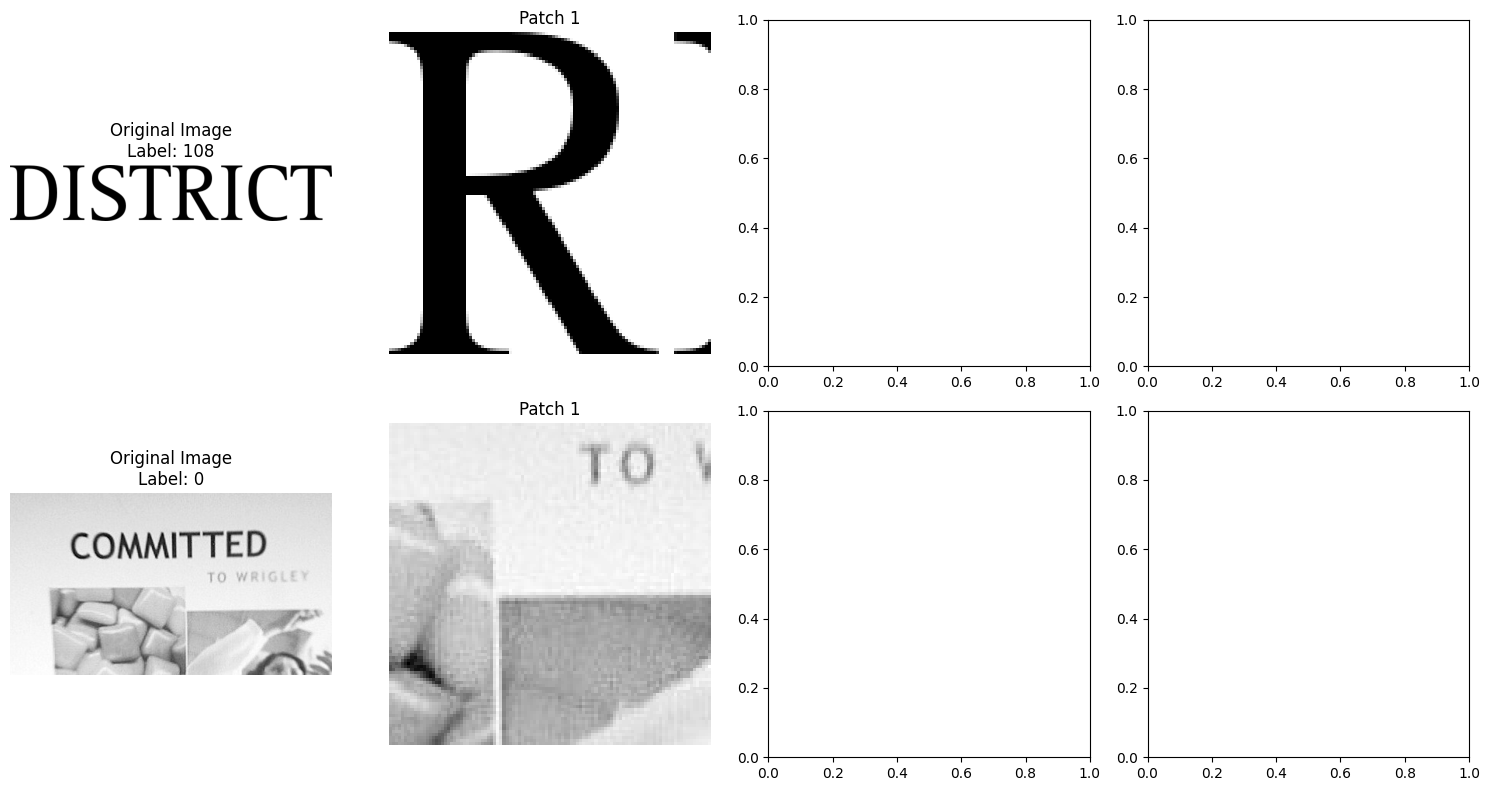

In [13]:
# Visualization some samples from the combined dataset

def visualize_simple_images_and_patches(dataset, num_images=2):
    """
    Visualizes full images and their extracted patches in a simple layout.
    Shows only 2 images and their 3 patches in a clean format.
    
    Args:
        dataset: A CombinedImageDataset or BCFImagePatchDataset instance
        num_images: Number of images to visualize (default: 2)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    
    # Select random indices from the dataset
    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(num_images, 4, figsize=(15, 4 * num_images))
    
    # If only one image is requested, make axes indexable as 2D
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Get item directly from dataset
        patches, label = dataset[idx]
        
        # If no patches were extracted (image too small), skip this image
        if not patches:
            continue
            
        # Get the original full image
        if hasattr(dataset, 'jpeg_data') and idx < len(dataset.jpeg_data):
            # From jpeg_data
            img_path, _ = dataset.jpeg_data[idx]
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
        elif hasattr(dataset, 'image_filenames') and not hasattr(dataset, 'num_images'):
            # From BCFImagePatchDataset with JPEG source
            img_path = os.path.join(dataset.data_source, dataset.image_filenames[idx])
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
        else:
            # From BCF file (either CombinedImageDataset or BCFImagePatchDataset)
            if hasattr(dataset, 'bcf_data'):
                # CombinedImageDataset
                bcf_idx = idx - len(dataset.jpeg_data)
                offset = dataset.image_offsets[bcf_idx]
                size = dataset.image_sizes[bcf_idx]
                data_file = dataset.bcf_file
                data_start = dataset.data_start_offset
            else:
                # BCFImagePatchDataset
                offset = dataset.image_offsets[idx]
                size = dataset.image_sizes[idx]
                data_file = dataset.data_source
                data_start = dataset.data_start_offset
                
            with open(data_file, 'rb') as f:
                f.seek(data_start + offset)
                image_bytes = f.read(size)
            img = Image.open(BytesIO(image_bytes)).convert('L')
            img_array = np.array(img)
        
        # Plot original image
        axes[i, 0].imshow(img_array, cmap='gray')
        axes[i, 0].set_title(f"Original Image\nLabel: {label}")
        axes[i, 0].axis('off')
        
        # Plot the 3 patches
        for j in range(min(3, len(patches))):
            axes[i, j+1].imshow(patches[j], cmap='gray')
            axes[i, j+1].set_title(f"Patch {j+1}")
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_simple_images_and_patches(combined_dataset)

In [3]:
# train_memory_efficient_model

import torch.cuda.amp as amp
import gc

def train_memory_efficient_model(model, train_loader, val_loader=None, 
                                num_epochs=5, learning_rate=0.0001,
                                checkpoint_dir="/kaggle/working/"):
    """
    Memory-efficient training function for SCAE model.
    """
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Setup device and optimization tools
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device} with {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")
    
    # Move model to device
    model = model.to(device)
    
    # Set up mixed precision training
    scaler = amp.GradScaler()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    # Track best model
    best_val_loss = float('inf')
    patience_counter = 0
    
    try:
        for epoch in range(num_epochs):
            # Clean memory before each epoch
            gc.collect()
            torch.cuda.empty_cache()
            
            # TRAINING PHASE
            model.train()
            running_loss = 0.0
            valid_batches = 0
            
            # Use tqdm for progress tracking
            pbar = tqdm(train_loader)
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train]")
            
            for batch_idx, (patches, _) in enumerate(pbar):
                # Skip empty batches
                if patches.numel() == 0:
                    continue
                
                # Move data to device
                patches = patches.to(device, non_blocking=True)
                
                # Mixed precision forward pass
                with amp.autocast():
                    outputs = model(patches)
                    loss = criterion(outputs, patches)
                
                # Backward pass with gradient scaling
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update metrics
                running_loss += loss.item()
                valid_batches += 1
                
                # Update progress bar
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                
                # Aggressive memory cleanup every few batches
                if batch_idx % 10 == 0:
                    del outputs, loss, patches
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            # Calculate epoch metrics
            if valid_batches > 0:
                train_loss = running_loss / valid_batches
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, No valid batches!")
                continue
                
            # Save checkpoint every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pt")
            
            # VALIDATION PHASE
            if val_loader:
                val_loss = validate_memory_efficient(model, val_loader, criterion, device)
                scheduler.step(val_loss)
                
                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pt")
                    print(f"New best model saved with val_loss: {val_loss:.6f}")
                else:
                    patience_counter += 1
                    if patience_counter >= 3:  # Adjust patience as needed
                        print("Early stopping triggered!")
                        break
    
    except Exception as e:
        print(f"Error during training: {e}")
        # Save emergency checkpoint
        torch.save(model.state_dict(), f"{checkpoint_dir}/emergency_model.pt")
        raise
        
    return model

def validate_memory_efficient(model, val_loader, criterion, device):
    """Memory-efficient validation function."""
    model.eval()
    running_loss = 0.0
    valid_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader)
        pbar.set_description(f"Validating")
        
        for patches, _ in pbar:
            if patches.numel() == 0:
                continue
                
            patches = patches.to(device, non_blocking=True)
            
            # Using mixed precision even for validation
            with amp.autocast():
                outputs = model(patches)
                loss = criterion(outputs, patches)
                
            running_loss += loss.item()
            valid_batches += 1
            
            # Update progress bar
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
            # Clean up
            del outputs, patches, loss
    
    if valid_batches > 0:
        val_loss = running_loss / valid_batches
        print(f"Validation Loss: {val_loss:.6f}")
        return val_loss
    else:
        print("No valid validation batches!")
        return float('inf')

In [5]:
# memory_efficient_patch_collate_fn
import gc
import warnings
from functools import partial

# Add this memory-efficient patch collate function
def memory_efficient_patch_collate_fn(batch, patch_size_tuple):
    """
    Memory-efficient version of patch_collate_fn that processes one patch at a time
    and includes robust error handling.
    """
    import gc  # Import inside function for worker processes
    
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    # Process one item at a time to avoid large memory allocations
    for item in batch:
        patches, label = item
        # Ensure item is valid
        if patches and label != -1:
            # Process patches one by one
            for patch in patches:
                all_patches.append(patch)
                all_labels.append(label)
            valid_batch_items += 1
    
    # Periodically force garbage collection
    if len(all_patches) > 100:
        gc.collect()
    
    # Empty batch handling
    if not all_patches:
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Process in smaller chunks to reduce peak memory usage
    max_chunk_size = 64  # Adjust based on your GPU memory
    num_patches = len(all_patches)
    patches_tensor_list = []
    
    for i in range(0, num_patches, max_chunk_size):
        chunk = all_patches[i:i+max_chunk_size]
        # Convert to NumPy array
        chunk_np = np.stack(chunk)
        # Convert to tensor, normalize and add channel dimension
        chunk_tensor = torch.from_numpy(chunk_np).float() / 255.0
        chunk_tensor = chunk_tensor.unsqueeze(1)
        patches_tensor_list.append(chunk_tensor)
        
        # Clear variables to free memory
        del chunk, chunk_np
    
    # Concatenate chunks
    patches_tensor = torch.cat(patches_tensor_list, dim=0)
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)
    
    # Clean up
    del patches_tensor_list, all_patches, all_labels
    gc.collect()
    
    return patches_tensor, labels_tensor

# Add this function to create optimized DataLoaders
def create_optimized_dataloaders(combined_dataset, batch_size=256, num_workers=2, patch_size=(105, 105), 
                               train_ratio=0.8, val_ratio=0.1):
    """
    Creates memory-efficient DataLoaders with proper error handling and optimized parameters.
    """
    # Split dataset
    train_size = int(train_ratio * len(combined_dataset))
    val_size = int(val_ratio * len(combined_dataset))
    test_size = len(combined_dataset) - train_size - val_size
    
    train_subset, val_subset, test_subset = torch.utils.data.random_split(
        combined_dataset, [train_size, val_size, test_size]
    )
    
    # Create collate function with patch size
    collate_fn = partial(memory_efficient_patch_collate_fn, patch_size_tuple=patch_size)
    
    # Set persistent_workers=True to avoid recreating worker processes
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False,
        prefetch_factor=2 if num_workers > 0 else None,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size,
        shuffle=False, 
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False
    )
    
    test_loader = DataLoader(
        test_subset, 
        batch_size=batch_size,
        shuffle=False, 
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False
    )
    
    return train_loader, val_loader, test_loader

In [6]:
# SCAE
import torch.nn as nn
class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="leaky_relu"):
        super(SCAE, self).__init__()

        def norm_layer(num_features):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm":
                return nn.LayerNorm([num_features, 26, 26])  # Adjusted for bottleneck size
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=1, padding=5),  # 105x105 -> 105x105
            norm_layer(64),
            activation_layer(),
            dropout_layer(),

            nn.MaxPool2d(2, 2),  # 105x105 -> 52x52

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 52x52 -> 52x52
            norm_layer(128),
            activation_layer(),
            dropout_layer(),

            nn.MaxPool2d(2, 2)  # 52x52 -> 26x26
        )

        # Decoder - Using U-Net style architecture with precise sizing
        self.decoder = nn.Sequential(
            # First upsampling: 26x26 -> 52x52
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),

            # Second upsampling: 52x52 -> 105x105
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0, output_padding=1),
            norm_layer(32),
            activation_layer(),
            dropout_layer(),

            # Final convolution to get single channel
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # For image reconstruction (values between 0-1)
        )

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
            # print(x.shape)
        for layer in self.decoder:
            x = layer(x)
            # print(x.shape)
        return x

In [7]:
# load dataset -> create dataloader -> training script
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm

# Clean memory before starting
gc.collect()
torch.cuda.empty_cache()

jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
bcf_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label"

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print(f"Available memory: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Create dataset with smaller patch size and fewer patches per image
combined_dataset = CombinedImageDataset(
    jpeg_dir=jpeg_dir,
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=1,  # Reduced from 3
    patch_size=(105, 105)  # Smaller than 105x105
)

# Create memory-optimized dataloaders with smaller batch size
train_loader, val_loader, test_loader = create_optimized_dataloaders(
    combined_dataset,
    batch_size=128,  # Reduced from 1024
    num_workers=2,   # Reduced from 4
    patch_size=(105, 105)
)

# Create model and train with memory optimization
model = SCAE()
trained_model = train_memory_efficient_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    learning_rate=0.0001
)

Using GPU: Tesla P100-PCIE-16GB
Total memory: 17.06 GB
Available memory: 0.00 GB
Loaded 82389 .jpeg images.
Loaded 202000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 202000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 202000 .bcf images.
Training on cuda with Tesla P100-PCIE-16GB
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB


/tmp/ipykernel_551/3070266538.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1/3 [Train]:   0%|          | 0/1778 [00:00<?, ?it/s]/tmp/ipykernel_551/3070266538.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1/3 [Train]:  46%|████▌     | 814/1778 [03:12<03:21,  4.78it/s, loss=0.0017]

Epoch 1/3 [Train]:  65%|██████▍   | 1155/1778 [04:33<02:38,  3.92it/s, loss=0.0015]

Epoch 1/3 [Train]:  87%|████████▋ | 1546/1778 [06:06<00:55,  4.18it/s, loss=0.0011]

Epoch 1/3 [Train]: 100%|██████████| 1778/1778 [07:02<00:00,  4.21it/s, loss=0.0015]


Epoch 1/3, Train Loss: 0.006134


Validating:   0%|          | 0/223 [00:00<?, ?it/s]/tmp/ipykernel_551/3070266538.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating: 100%|██████████| 223/223 [00:51<00:00,  4.30it/s, loss=0.0015]


Validation Loss: 0.001024
New best model saved with val_loss: 0.001024


Epoch 2/3 [Train]:   4%|▍         | 79/1778 [00:17<06:32,  4.32it/s, loss=0.0011]

Epoch 2/3 [Train]:  31%|███       | 546/1778 [02:00<04:34,  4.49it/s, loss=0.0006]

Epoch 2/3 [Train]:  52%|█████▏    | 933/1778 [03:27<02:57,  4.77it/s, loss=0.0014]

Epoch 2/3 [Train]:  52%|█████▏    | 933/1778 [03:27<02:57,  4.77it/s, loss=0.0005]

Epoch 2/3 [Train]: 100%|██████████| 1778/1778 [06:34<00:00,  4.51it/s, loss=0.0008]


Epoch 2/3, Train Loss: 0.000841


Validating: 100%|██████████| 223/223 [00:45<00:00,  4.86it/s, loss=0.0010]


Validation Loss: 0.000670
New best model saved with val_loss: 0.000670


Epoch 3/3 [Train]:  20%|██        | 362/1778 [01:14<04:59,  4.73it/s, loss=0.0004]

Epoch 3/3 [Train]:  29%|██▉       | 517/1778 [01:45<04:18,  4.87it/s, loss=0.0006]

Epoch 3/3 [Train]:  83%|████████▎ | 1476/1778 [05:09<01:09,  4.37it/s, loss=0.0005]

Epoch 3/3 [Train]: 100%|██████████| 1778/1778 [06:14<00:00,  4.74it/s, loss=0.0007]


Epoch 3/3, Train Loss: 0.000609


Validating: 100%|██████████| 223/223 [00:46<00:00,  4.79it/s, loss=0.0008]

Validation Loss: 0.000535
New best model saved with val_loss: 0.000535


In [8]:
torch.save(model.state_dict(), "/kaggle/working/checkpoint")

Using device: cuda
Model loaded successfully


/tmp/ipykernel_551/32495165.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 82389 .jpeg images.
Loaded 3202 labels from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label.
Loaded 3202 images from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf.
Loaded 3202 .bcf images.
Dataset and DataLoader prepared

1. Evaluating reconstruction quality...
Reconstruction Metrics:
  Average MSE: 0.0017
  Average SSIM: 0.9279 (higher is better, max 1.0)
  Average PSNR: 29.24 dB (higher is better)
Saved reconstruction comparison to evaluation_results


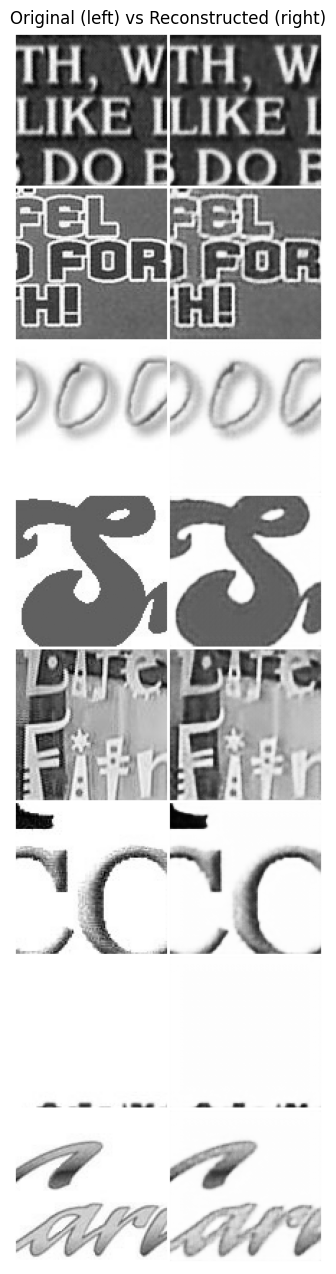

GPU memory allocated: 0.00 GB

2. Evaluating classification performance...
Model doesn't appear to have classification capability
GPU memory allocated: 0.00 GB

3. Visualizing latent space with t-SNE...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

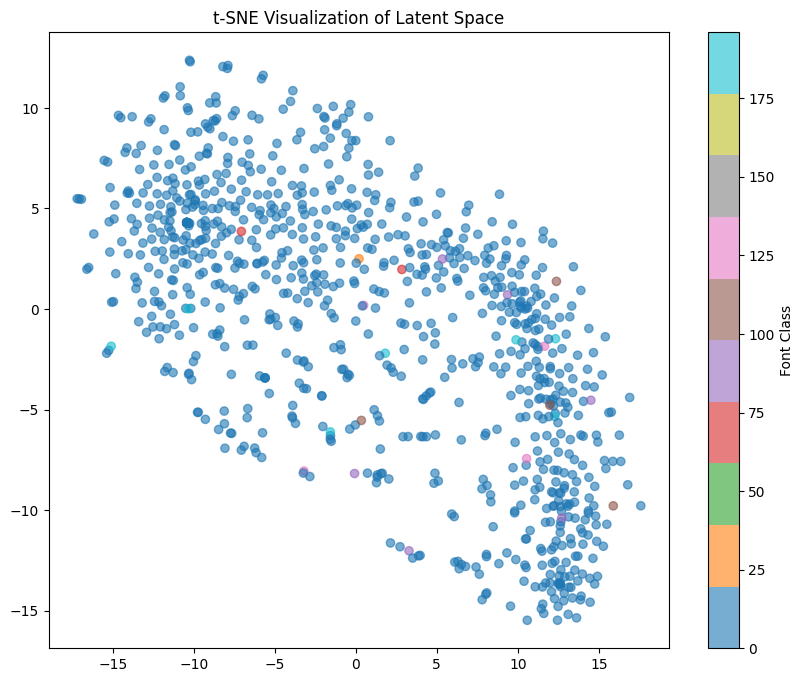

GPU memory allocated: 0.00 GB

4. Generating samples from latent space...
Model doesn't have a decode method. Cannot generate samples.
GPU memory allocated: 0.00 GB

5. Creating latent space interpolation...


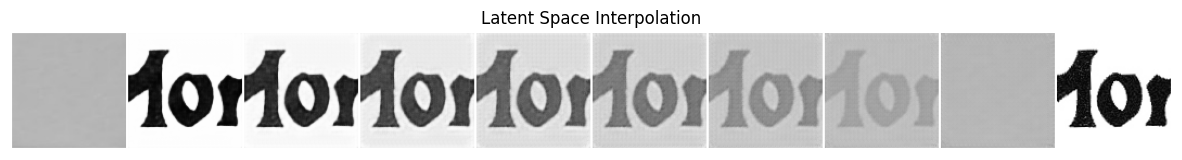

GPU memory allocated: 0.00 GB

Evaluation complete! Results saved to evaluation_results


In [12]:
# test
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from functools import partial
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import gc


def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE) 
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # Calculate SSIM (structural similarity index)
                ssim_val = ssim(img, recon, data_range=1.0)
                total_ssim += ssim_val
                
                # Calculate PSNR (peak signal-to-noise ratio)
                psnr_val = psnr(img, recon, data_range=1.0)
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    avg_mse = total_mse / (count // batch_size + 1)
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def evaluate_classification(model, dataloader, device, num_classes, save_path=None):
    """
    Evaluate classification performance if your SCAE includes classification capability
    """
    model.eval()
    
    # Check if model has a classify method or classification head
    if not hasattr(model, 'classify') and not hasattr(model, 'classification_head'):
        print("Model doesn't appear to have classification capability")
        return None
        
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions - adapt this to your model's API
            try:
                if hasattr(model, 'classify'):
                    preds = model.classify(images)
                else:
                    # Assume model returns (reconstructions, classifications) if called with return_classifications=True
                    _, preds = model(images, return_classifications=True)
                
                # Convert to class indices
                _, predicted = torch.max(preds.data, 1)
                
                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            except Exception as e:
                print(f"Error during classification evaluation: {e}")
                return None
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Classification Accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                if images.numel() == 0:
                    continue
                    
                images = images.to(device)
                
                # Get latent vectors - adapt this to your model's API
                if hasattr(model, 'encode'):
                    latent = model.encode(images)
                else:
                    # Try to extract the latent representation from your model
                    # This depends on your model's architecture
                    x = images
                    for layer in model.encoder:
                        x = layer(x)
                    latent = x
                
                # Flatten the latent vectors
                batch_size = images.size(0)
                latent_flat = latent.view(batch_size, -1).cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.numpy())
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        latent_vectors = np.vstack(latent_vectors)
        labels = np.concatenate(labels)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latent_vectors)
        
        # Plot t-SNE results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, label='Font Class')
        plt.title('t-SNE Visualization of Latent Space')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
        plt.show()
        
        return latent_tsne, labels
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None

def generate_samples_from_latent(model, num_samples=10, latent_dim=128, device=None, save_path=None):
    """
    Generate new images by sampling from the latent space (like in VAE)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    
    try:
        # Generate random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)
        
        # Generate images
        with torch.no_grad():
            if hasattr(model, 'decode'):
                generated = model.decode(z)
            else:
                print("Model doesn't have a decode method. Cannot generate samples.")
                return None
        
        # Visualize generated images
        grid = make_grid(generated.cpu(), nrow=5, normalize=True, pad_value=1)
        plt.figure(figsize=(12, 6))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Generated Samples from Random Latent Vectors')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'generated_samples.png'), bbox_inches='tight')
        plt.show()
        
        return generated
        
    except Exception as e:
        print(f"Error generating samples from latent space: {e}")
        print(f"Your model might not support the VAE-style generation.")
        return None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        for images, _ in dataloader:
            if images.shape[0] >= 2 and images.numel() > 0:
                break
        else:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = images[0:1].to(device)
        img2 = images[1:2].to(device)
        
        # Get latent representations
        with torch.no_grad():
            if hasattr(model, 'encode'):
                z1 = model.encode(img1)
                z2 = model.encode(img2)
            else:
                # Try to extract the latent representation
                x1 = img1
                x2 = img2
                for layer in model.encoder:
                    x1 = layer(x1)
                    x2 = layer(x2)
                z1 = x1
                z2 = x2
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Decode the interpolated latent vector
                if hasattr(model, 'decode'):
                    decoded = model.decode(z_interp)
                else:
                    decoded = model.decoder(z_interp)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = [img1.cpu()]
        all_images.extend([interp.cpu() for interp in interpolations])
        all_images.append(img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        return None

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "/kaggle/working/evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        test_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir, 
            bcf_file=bcf_file, 
            label_file=label_file,
            num_patch=1,  # Use fewer patches to save memory
            patch_size=(105, 105)
        )
        
        # Create test loader with smaller batch size
        collate_fn = partial(patch_collate_fn, patch_size_tuple=(105, 105))
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=32,  # Use a smaller batch size
            shuffle=True,   # Shuffle to get diverse examples
            num_workers=2,
            collate_fn=collate_fn
        )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # If model has classification capability, evaluate it
        print("\n2. Evaluating classification performance...")
        try:
            class_metrics = evaluate_classification(
                model, test_loader, device, num_classes=2383, save_path=save_dir
            )
        except:
            print("Classification evaluation skipped - model may not support classification")
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n3. Visualizing latent space with t-SNE...")
        latent_tsne, labels = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Generate samples from random latent vectors (if model supports it)
        print("\n4. Generating samples from latent space...")
        try:
            # Determine latent dimension from model structure
            # This is just a guess - adapt to your model
            latent_dim = 128
            generated_samples = generate_samples_from_latent(
                model, num_samples=16, latent_dim=latent_dim, device=device, save_path=save_dir
            )
        except:
            print("Sample generation skipped - model may not support VAE-style generation")
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n5. Creating latent space interpolation...")
        try:
            interpolations = interpolate_latent_space(
                model, test_loader, device, steps=8, save_path=save_dir
            )
        except:
            print("Latent interpolation skipped - model may not support this operation")
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

# Augumentation Steps 
1) Noise
2) Blur
3) Perpective Rotation
4) Shading
5) Variable Character Spacing
6) Variable Aspect Ratio

In [ ]:
# augmentation functions
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img

def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian